# [Жёлтое такси в Нью-Йорке](https://www.coursera.org/learn/data-analysis-project/supplement/NuH2K/zhioltoie-taksi-v-n-iu-iorkie)

Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти боро города.

Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая информация о поездках:
* VendorID провайдер данных (одна из двух категорий)
* tpep_pickup_datetime - время начала поездки
* tpep_dropoff_datetime - время окончания поездки
* passenger_count - количество пассажиров
* trip_distance - расстояние по счётчику
* pickup_longitude &	pickup_latitude - долгота и широта точки начала поездки
* dropoff_longitude	& dropoff_latitude - долгота и широта точки окончания поездки
* RatecodeID - тип тарифа (одна из шести категорий)
* store_and_fwd_flag	- бинарный флаг, показывающий, были ли данные о поездке получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля
* payment_type - способ оплаты (одна из шести категорий)
* fare_amount - стоимость поездки по счётчику
* extra - доплата за поездки в пиковые часы и ночью
* mta_tax - налог на счётчик
* tip_amount - размер чаевых
* tolls_amount - доплата за проезд по платным дорогам
* improvement_surcharge	- доплата за проезд, взимаемая с каждой поездки с января 2015
* total_amount - общая стоимость поездки

Подробнее: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Задача проекта — научиться предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка; для простоты мы определим прямоугольные районы. Для того, чтобы её решить, сырые данные необходимо агрегировать по часам и районам. Агрегированные данные будут представлять собой почасовые временные ряды с количествами поездок из каждого района.

Задачу прогнозирования таких рядов можно решать с помощью авторегрессионных моделей, прогнозируя каждый ряд независимо. Ряды явно имеют сложную сезонность — суточную, недельную и годовую, поэтому для их моделирования понадобится использовать модель ARIMA с дополнительной регрессией на внешние признаки.

Чтобы улучшить такую модель, можно попытаться учесть:

* взаимосвязи между рядами
* дополнительные параметры поездок, которые можно посчитать по исходным данным
* внешние календарные и географические признаки

В ходе выполнения проекта вы научитесь:

* работать с геоданными
* прогнозировать временные ряды сложной структуры
* строить и настраивать регрессионные модели, делающие совместные предсказания для большого количества взаимосвязанных рядов

Похожие задачи возникают на практике, если вам необходимо спрогнозировать продажи большого количества товаров в большом количестве магазинов, объём снятия денег в сети банкоматов, посещаемость разных страниц сайта и т.д.

В ходе выполнения проекта у вас будет свобода выбора хода решения, используемых средств анализа, библиотек и моделей. Также обратите внимание, что для его успешного выполнения вам нужно будет скачать и обработать от 10 до 200 гигабайт сырых данных.

In [1]:
%pylab inline

from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


---

# [Week 1 - Знакомство с данными и агрегация](https://www.coursera.org/learn/data-analysis-project/peer/q7Gpv/znakomstvo-s-dannymi-i-aghrieghatsiia) 

Скачайте сырые данные о поездках жёлтого такси с сайта TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

Поездки зелёного такси и лимузинов нас не интересуют!

Данные выложены в файлах по месяцам. Скачайте так много данных жёлтого такси, как сможете; чем больше вы будете использовать данных, тем точнее получатся ваши прогнозы. Если вы решите использовать не все данные, а только часть, выбирайте её по времени с конца. Абсолютный минимум необходимых данных — 6 месяцев: один, последний месяц, вам понадобится для тестирования, предшествующие 5 — для обучения. По 5 месяцам можно построить прогнозы, учитывающие дневную и недельную сезонности, но в данных есть и годовая. Чтобы её учесть, необходимы данные как минимум за 2 года.

Обработайте сырые данные по следующей схеме.

1. Почистите данные от ошибок и аномалий.
2. Отбросьте минуты и секунды во времени начала поездки.
3. Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. Разбейте этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.
4. Посчитайте количество поездок за каждый час из каждой области. Не забудьте, что если в сырых данных для какой-то пары час-область нет ни одной записи, то в агрегированных данных для неё должен стоять 0.

В дальнейшем, когда вы будете предсказывать получившиеся ряды, нужно будет загружать ваши прогнозы на kaggle, поэтому нужно, чтобы идентификаторы ячеек были определены однозначно. В следующем файле даны идентификаторы ячеек, которые вам нужно использовать, и географические координаты их границ:

Для сдачи задания этой недели вам нужно агрегировать только данные за май 2016, но, когда задание будет сдано, не забудьте запустить ваш агрегирующий скрипт на всех остальных месяцах, которые вы собираетесь использовать при прогнозировании.

Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите данные за май 2016 года.

In [3]:
df_1605 = pd.read_csv('data/yellow_tripdata_2016-05.csv') # , sep=';', index_col=['region']

2. Проведите фильтрацию: удалите поездки с
    * нулевой длительностью
    * нулевым количеством пассажиров
    * нулевым расстоянием поездки по счётчику
    * координатами начала, не попадающими в прямоугольник Нью-Йорка

    Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

In [4]:
def clear_df_month(df):
    df.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(df.loc[:,'tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(df.loc[:,'tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
    df.loc[:, 'tpep_pickup_datetime_h'] = pd.to_datetime(df.loc[:,'tpep_pickup_datetime'].apply(lambda x: str(x)[0:13] + ":00:00"),
                                                         format='%Y-%m-%d %H:%M:%S')
    df.loc[:, 'count'] = 1
    return df[((df.tpep_dropoff_datetime - df.tpep_pickup_datetime) > timedelta(0))
                & (df.passenger_count > 0)
                & (df.trip_distance > 0)
                & (((df.pickup_longitude > NY_longitude[0]) & (df.pickup_longitude < NY_longitude[1]))
                  & ((df.pickup_latitude > NY_latirude[0]) & (df.pickup_latitude < NY_latirude[1])))]

In [5]:
df_regions = pd.read_csv('data/regions.csv', sep=';', index_col=['region'])

NY_longitude = (-74.25559, -73.70001)
NY_latirude = (40.49612, 40.91553)

bin_NY_longitude = list(set(df_regions.west.values))
bin_NY_longitude.append(NY_longitude[1])
bin_NY_longitude.sort()
bin_NY_latirude = list(set(df_regions.south.values))
bin_NY_latirude.append(NY_latirude[1])
bin_NY_latirude.sort()

In [6]:
%%time
df_1605_clear = clear_df_month(df_1605)

Wall time: 6min 20s


3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

In [7]:
def agreg_df_month(df):
    ret = stats.binned_statistic_2d(x=df.pickup_longitude.values,
                                    y=df.pickup_latitude.values,
                                    values=df.VendorID,
                                    statistic='count',
                                    bins=[bin_NY_longitude, bin_NY_latirude],
                                    expand_binnumbers=True)
    df['region'] = (ret[3][0] - 1) * 50 + ret[3][1]
    return df

In [8]:
%%time
df_1605_clear = agreg_df_month(df_1605_clear)

Wall time: 14.7 s


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [9]:
def generate_period(df, year_start, month_start, year_end=None, month_end=None, region=df_regions.index):
    if year_end==None or month_end==None:
        if month_start > 0 and month_start < 12:
            period = pd.date_range(str(month_start) + '/1/' + str(year_start), str(month_start+1) + '/1/' + str(year_start), freq="1H")[:-1]
        elif month_start == 12:
            period = pd.date_range(str(month_start) + '/1/' + str(year_start), str(1) + '/1/' + str(year_start+1), freq="1H")[:-1]
        else:
            print('Не верный формат данных')
    else:
        period = pd.date_range(str(month_start) + '/1/' + str(year_start), str(month_end) + '/1/' + str(year_end), freq="1H")[:-1]
    
    df = df.loc[:, ['region', 'tpep_pickup_datetime_h', 'count']].groupby(['region','tpep_pickup_datetime_h']).count()
    df.reset_index(inplace=True)  
    
    df_gen = pd.DataFrame(np.zeros((period.shape[0], region.shape[0])), index=period, columns=region)
    
    for i in set(df.region.values):
        df_temp_gen = df.loc[:, ['tpep_pickup_datetime_h', 'count']][df.region == i]

        for j in df_temp_gen.tpep_pickup_datetime_h:
            df_gen.loc[j, i] = int(df_temp_gen['count'][df_temp_gen.tpep_pickup_datetime_h == j].values)

    return df_gen

In [10]:
%%time
df_1605_clear = generate_period(df_1605_clear, 2016, 5)

Wall time: 14min 4s


5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [11]:
def search_on_gps(search_longitude, search_latirude):
    '''Поиск номера региона для объектв по GPS'''
    return df_regions[((df_regions.west<search_longitude) & (df_regions.east>search_longitude))
                    & ((df_regions.north>search_latirude) & (df_regions.south<search_latirude))].index.values[0]

In [12]:
# Координаты Empire State Building - (-73.985664, 40.748441)
ISB_region = search_on_gps(-73.985664, 40.748441)

In [13]:
def plot_region(df, region):
    '''Построение графика зависимости региона от времени'''
    plt.figure(figsize(15,7))
    df[region].plot(fontsize=14)
    plt.ylabel('Количество поездов такси в ' + str(region) + ' ячейке', fontsize=14)
    pylab.show()

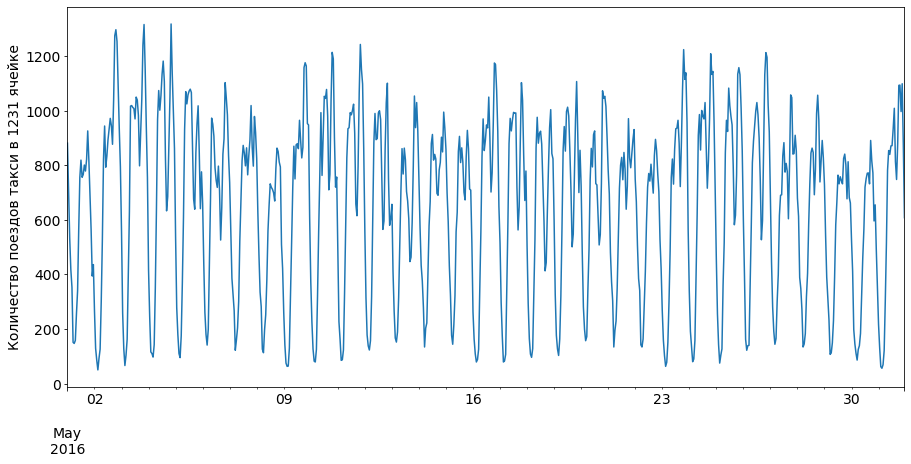

In [14]:
plot_region(df_1605_clear, ISB_region)

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [15]:
def count_zero_region(df):
    count = []
    for i in df:
        count.append(df[i][df[i] == 0].shape[0])
    return count

In [16]:
print("В мае 2016 было в {} парах час-ячейка не было совершено ни одной поездки".format(sum(count_zero_region(df_1605_clear))))

В мае 2016 было в 1718238 парах час-ячейка не было совершено ни одной поездки


7. Загрузите ноутбук в форму ниже

In [17]:
df_1605_clear.to_csv('data/week1_end.csv')